# size distribution example
Load basic packages

In [1]:
import size_distribution_class as sdc
import statistics

import pandas as pd
import pandas_bokeh
import numpy as np
from pylab import *
from scipy.optimize import curve_fit
import scipy

from bokeh.io import output_file, output_notebook
from bokeh.models import DatetimeTickFormatter, ranges, Span, Label, Range1d, LinearAxis
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from bokeh.palettes import linear_palette, Turbo256
from matplotlib import pyplot as plt
pd.set_option('plotting.backend', 'pandas_bokeh')
output_notebook(hide_banner=True)
from IPython.core.display import display, HTML



In [2]:
psd = sdc.File_Process( verbose=True, analyze_color_name='white', analyze_color_BGR=[0,0,255], min_cld_length=5, force_reprocessing=False )

Please select the image to analyse.
--------------------------------------------------
Analysing 03 segmented_0_1.tif
size: 23737.56 x 23788.15 nm / 1877 x 1881 px 
loaded psd csv
--------------------------------------------------
loaded cld csv


## Loaded image

In [3]:
hist, bins = psd.get_cleaned_histogram_list('cld', 'diameter')
print(len(hist),len(bins))
hist, bins = psd.get_histogram_list('cld', 'diameter')
print(len(hist),len(bins))

1288 1289
1878 1879


In [4]:
print(psd.folder)

D:/Maps/2019_04_03 C3S 7d Anschliff 2/Auswertung/03 segmented


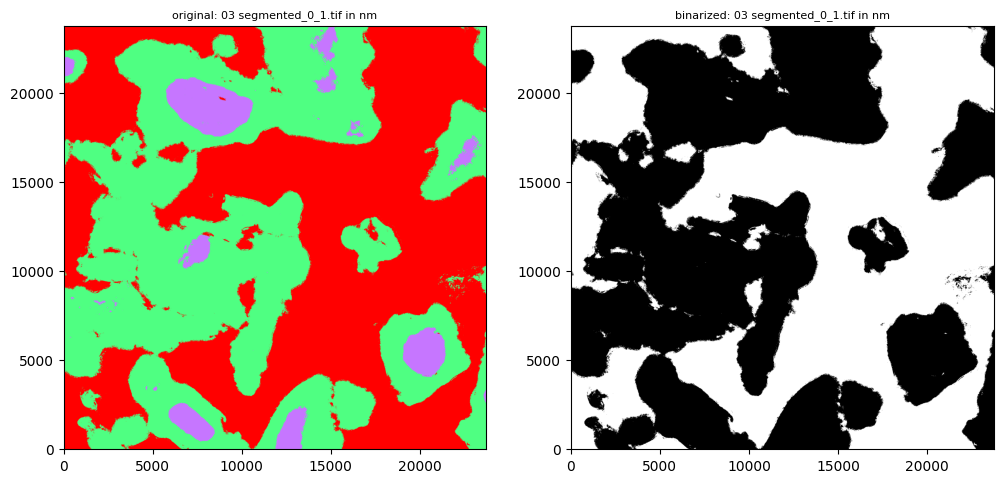

In [5]:
psd.plot_images()

## Basic functions to generate the following diagrams

In [18]:
def get_X_List( values ):
    value_cnt = len(values)
    x_range = list(range(value_cnt))
    x_range.pop(0)
    x_range.append(value_cnt)
    return x_range

def get_x(x, c):
    c_len = len(c)
    if c_len == 1:
        return c[0]
    else:
        return get_x(x, c[:-1])*x + c[c_len-1]

def get_polyfit_xy( x, y, deg=3, resolution=1 ):
    c = np.polynomial.polynomial.polyfit(x, y, deg)

    x_result = np.linspace(x[0], x[-1], num=len(x)*10)
    y_result = np.polynomial.polynomial.polyval(x_result, c)
    return x_result,y_result

def extrapolation_function(x, a, b, c):
    return a * np.exp(-b * x) + c

# see https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution
def inv_gaussian_dist(x, lamb, mu, c=1.0):
    # since this causes problems with the curve_fit function and x is always larger than 0 in this case, the following two lines are not needed
    #if x <= 0.0:
    #    return 0.0              
    return c * np.sqrt( lamb / ( 2.0 * np.pi * x**3 )) * np.exp( ( -lamb * (x - mu)**2 ) / ( 2 * mu**2 * x ) )

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fatiguelife.html#scipy.stats.fatiguelife
def fatiguelife(x, c):
    return scipy.stats.fatiguelife.pdf(x, c)#, loc, scale

def pareto(x,c):
    return scipy.stats.pareto.pdf(x, c)#, loc, scale

def powerlognorm(x, c, s):
    return scipy.stats.powerlognorm.pdf(x, c, s)

def get_histogram(dist_type='cld', x_column='diameter',y_column='count', max_value=None, plot_width=1200, legend_location='top_right', smoothing=0, do_fit=False, show_sum_list=False):
    # some basic label settings
    if dist_type == 'psd':
        df = psd.psd_df
        dist_name = 'pore size distribution'
        x_min_f=1
    else:
        df = psd.cld_df
        dist_name = 'chord length distribution'
    
    unit, power = psd.get_column_unit( x_column )


    # get & process the actual histogram
    hist, bins = psd.get_cleaned_histogram_list(dist_type, x_column, y_column)
    #hist, bins = get_histogram_list(dist_type, x_column, y_column)
    x_min = bins[0]
    if max_value == None: max_value = bins[-1]
    x_max = bins[-1] if max_value >= bins[-1] else max_value
    
    title = '{} as {} of {} up to {} {}'.format(dist_name, x_column, psd.filename, max_value, unit)
    x_label = 'pore size ({}) in {}'.format(x_column, unit)
    y_label = 'amount of items in %'


    #todo: Auftragen von histogrammen x-Achse: diameter und y-Achse: [dia,area,vol,surf] -> histogram(anzahl) in histogramm(gesamtlänge/-fläche/-volumen)
    #todo: prüfen, ob die Anfänge/Enden der gecleanten bins stimmen

    if x_column=='area':
        x_axis_type='log'
    elif x_column=='volume':
        x_axis_type='log'
    elif x_column=='surface':
        x_axis_type='log'
    else:
        x_axis_type='linear'

    # get the center of the bins
    bin_center = sdc.get_bin_center(bins)

    # normalize the histograms
    normalized_hist = hist/(np.sum(hist*bin_center)/100)
    y_max=np.amax(normalized_hist)
    
    first_val_pos = 0
    
    # create the figure
    p = figure(title=title,  plot_width=plot_width, x_range=(x_min, x_max), y_range=(0,y_max), plot_height=600, background_fill_color="#fafafa", x_axis_type=x_axis_type)
    p.legend.location = legend_location
    p.xaxis.axis_label = x_label

    # histogram of raw data
    #p.quad(bottom=0, top=hist2, left=bin_size_area[1:], right=bin_size_area[:-1], fill_color="navy", line_color="navy")
    p.quad(bottom=0, top=normalized_hist, left=bins[1:], right=bins[:-1], fill_color="red", line_color="red")

    # smoothed raw data
    if smoothing > 2:
        hist_smooth = sdc.smooth_histogram(normalized_hist, window_len=smoothing)
        p.line(bin_center, hist_smooth, line_color="#ff88ff", line_width=4, alpha=0.7, legend_label="smoothed")

    #polynome fit
    #fit_deg=2
    #label="polynome fit of the degree {}".format(fit_deg)
    #x_fit, y_fit = get_polyfit_xy( bins[1:], hist, deg=fit_deg, resolution=100)
    #p.line(x_fit, y_fit, line_color="#111111", line_width=2, alpha=0.7, legend_label="fit")
    if do_fit:
        # fit to a predefined function
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html  lamb, mu, c
        
        first_val_y = bin_center[first_val_pos]

        #popt, pcov = curve_fit(inv_gaussian_dist, bin_center[first_val_pos:], normalized_hist[first_val_pos:])#normalized_hist)#, bounds=(0, [np.inf, np.inf, np.inf]))
        popt, pcov = curve_fit(powerlognorm, bin_center[first_val_pos:], normalized_hist[first_val_pos:], bounds=([0, -np.inf], np.inf))#, normalized_hist)#, bounds=(0, [np.inf, np.inf, np.inf]))
        #popt, pcov = curve_fit(fatiguelife, bin_center[first_val_pos:], normalized_hist[first_val_pos:], bounds=(0, np.inf))
        
        #print(first_val_pos, ':', first_val_y)
        #for i in range(9):
        #    print(bin_center[i], normalized_hist[i])
        label='-'
        #label='fit: lamb=%5.3f, mu=%5.3f, c=%5.3f' % tuple(popt)
        #label='fit: c=%5.3f' % tuple(popt)
        #print(bin_center[first_val_pos:][0])
        x_fit = np.linspace(int(bin_center[first_val_pos:][0]), int(bin_center[-1])+1, num=len(bin_center)*2)
        #y_fit = inv_gaussian_dist(x_fit-first_val_y, *popt)
        y_fit = powerlognorm(x_fit-first_val_y, *popt)
        #y_fit = fatiguelife(x_fit-first_val_y, *popt)
        p.line(x_fit, y_fit, line_color="#11aa11", line_width=2, alpha=0.7, legend_label=label)

    if show_sum_list:
        # iterated sum
        sum_list = psd.get_sum_list(normalized_hist)
        p.extra_y_ranges = {"sum_line": Range1d(start=0, end=np.amax(sum_list))}

        p.line(bins, sum_list, line_color="#ff8888", line_width=4, alpha=0.7, legend_label="Sum", y_range_name="sum_line")
        p.add_layout(LinearAxis(y_range_name="sum_line",axis_label=y_label), 'left')

    
    show(p)

generate Diagrams 

In [19]:
get_histogram('cld','diameter', max_value=1000, smoothing=7, do_fit=True, show_sum_list=False)

In [20]:
get_histogram('cld','diameter',y_column='area', max_value=1000, smoothing=7, do_fit=True, show_sum_list=False)

ValueError: operands could not be broadcast together with shapes (1288,) (1878,) 

In [21]:
get_histogram('cld','area', do_fit=True)

In [22]:
get_histogram('cld','surface', do_fit=True)

In [23]:
get_histogram('cld','volume', do_fit=True)

In [24]:
get_histogram('psd','diameter',1000, do_fit=True)

KeyError: 1000

In [25]:
get_histogram('psd','surface')

## statistics of the datasets

In [26]:
print('PSD')
columns = [ 'diameter', 'area', 'surface', 'volume']
for column in columns:
    col_max, col_mean, col_median = psd.get_basic_values(column, psd.psd_df)
    unit, _ = psd.get_column_unit( column )
    print('{} - max: {:.2f} {}, mean: {:.2f} {}, median: {:.2f} {}'.format(column, col_max, unit, col_mean, unit, col_median, unit))

PSD
diameter - max: 1382.52 nm, mean: 2.85 nm, median: 1.60 nm
area - max: 1501179.50 nm², mean: 428.80 nm², median: 2.00 nm²
surface - max: 6004718.00 nm², mean: 1715.19 nm², median: 8.00 nm²
volume - max: 1383606959.68 nm³, mean: 311642.39 nm³, median: 2.13 nm³


In [27]:
print('CLD')
columns = [ 'diameter', 'area', 'surface', 'volume']
for column in columns:
    col_max, col_mean, col_median = psd.get_basic_values(column, psd.cld_df)
    unit, _ = psd.get_column_unit( column )
    print('{} - max: {:.2f} {}, mean: {:.2f} {}, median: {:.2f} {}'.format(column, col_max, unit, col_mean, unit, col_median, unit))

CLD
diameter - max: 1289.00 nm, mean: 99.93 nm, median: 8.00 nm
area - max: 1121391795.63 nm², mean: 16440705.64 nm², median: 268.08 nm²
surface - max: 5219822.17 nm², mean: 142930.85 nm², median: 201.06 nm²
volume - max: 1121391795.63 nm³, mean: 16440705.64 nm³, median: 268.08 nm³


# experimental stuff

In [28]:
hist, bins = psd.get_histogram_list( psd.cld_df['diameter'], 1000, power=1 )

def fit_function_a(x, a, b, c):

    return a * np.exp(-b * x) + c


popt, pcov = curve_fit(fit_function_a, bins[:-1], hist) #, bounds=(0, [3., 1., 0.5]))
print(popt)

label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt)
fit_function_a(bins[:-1], *popt)
plt.plot(bins[:-1], fit_function_a(bins[:-1], *popt), 'g--', label=label)
plt.xlabel('x')

plt.ylabel('y')

plt.legend()

plt.show()

TypeError: get_histogram_list() got an unexpected keyword argument 'power'